In [1]:
from pydantic import BaseModel
from typing import List, Optional

class Product(BaseModel):
    id: int
    name: str
    time_series: Optional[List[float]] = []

class Division(BaseModel):
    id: int
    name: str
    products: List[Product]

class Segment(BaseModel):
    id: int
    name: str
    divisions: List[Division]


In [14]:
import numpy as np

def generate_time_series(pattern='flat', length=24):
    if pattern == 'flat':
        # Flat pattern with less variability
        return (np.full(length, 100) + np.random.normal(loc=0, scale=2, size=length)).tolist()
    elif pattern == 'declining':
        # Gradual decline with slight noise
        return (np.linspace(100, 80, num=length) + np.random.normal(loc=0, scale=3, size=length)).tolist()
    elif pattern == 'high: monthly':
        # More pronounced monthly seasonality
        return (100 + 15 * np.sin(np.linspace(0, 2*np.pi*2, num=length)) + np.random.normal(loc=0, scale=4, size=length)).tolist()
    elif pattern == 'high: quarterly':
        # Quarterly seasonality
        return (100 + 30 * np.sin(np.linspace(0, 2*np.pi*2/4, num=length)) + np.random.normal(loc=0, scale=5, size=length)).tolist()
    elif pattern == 'random walk':
        # Random walk pattern
        random_steps = np.random.normal(loc=0, scale=1, size=length)
        return np.cumsum(np.insert(random_steps, 0, 100)).tolist()[1:]
    else:
        # Default to a flat pattern if undefined
        return (np.full(length, 100) + np.random.normal(loc=0, scale=2, size=length)).tolist()


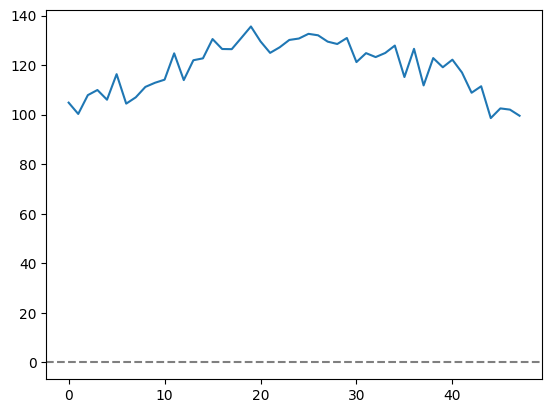

In [24]:
#plot the time series
import matplotlib.pyplot as plt
def plot_time_series(time_series):
    plt.plot(time_series)
    #show y = 0 line
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.show()

plot_time_series(generate_time_series('high: quarterly', 48))

In [27]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthBegin

def generate_time_series(pattern='flat', start_month='2023-01', months=12, seasonality_type='monthly'):
    # Create a date range starting from the specified month
    date_range = pd.date_range(start=start_month, periods=months, freq='MS')  # MS - Month Start frequency
    
    if pattern == 'flat':
        data = np.full(months, 100) + np.random.normal(loc=0, scale=2, size=months)
    
    elif pattern == 'declining':
        data = np.linspace(100, 80, num=months) + np.random.normal(loc=0, scale=3, size=months)
    
    elif pattern == 'seasonal':
        if seasonality_type == 'monthly':
            frequency = months / 12
        elif seasonality_type == 'quarterly':
            frequency = months / 4
        elif seasonality_type == 'weekly':
            frequency = months * 4.34524  # Approx. weeks per month
        else:
            raise ValueError("Invalid seasonality type. Choose from 'weekly', 'monthly', or 'quarterly'.")
        
        data = 100 + 20 * np.sin(2 * np.pi * np.arange(months) / frequency) + np.random.normal(loc=0, scale=5, size=months)
    
    elif pattern == 'random walk':
        random_steps = np.random.normal(loc=0, scale=1, size=months)
        data = np.cumsum(np.insert(random_steps, 0, 100))[1:]
    
    else:
        data = np.full(months, 100) + np.random.normal(loc=0, scale=2, size=months)
    
    # Create a Pandas Series with the date index
    return pd.Series(data, index=date_range)

# Example usage
time_series_data = generate_time_series(pattern='seasonal', start_month='2023-01', months=24, seasonality_type='monthly')
print(time_series_data)


2023-01-01    112.846890
2023-02-01     94.771650
2023-03-01     96.883716
2023-04-01     95.934988
2023-05-01    106.533299
2023-06-01    103.665264
2023-07-01    101.202968
2023-08-01    102.959987
2023-09-01     99.040803
2023-10-01    102.061740
2023-11-01    103.617183
2023-12-01     91.589825
2024-01-01    104.650357
2024-02-01     92.234050
2024-03-01    102.076589
2024-04-01    100.205509
2024-05-01    101.366783
2024-06-01    107.119126
2024-07-01     93.219926
2024-08-01    105.196145
2024-09-01    100.235694
2024-10-01     99.530360
2024-11-01     93.576030
2024-12-01     96.027142
Freq: MS, dtype: float64


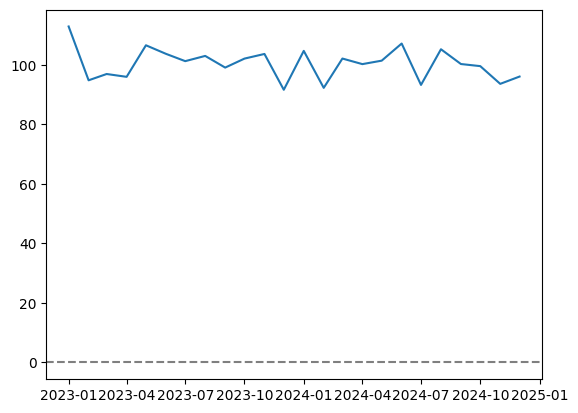

In [28]:
plot_time_series(time_series_data)

In [31]:
def generate_series_for_product(product, start_month, months, pattern, seasonality_type):
    product.time_series = generate_time_series(pattern, start_month, months, seasonality_type)

def generate_division_data(division, start_month, months, pattern, seasonality_type):
    for product in division.products:
        generate_series_for_product(product, start_month, months, pattern, seasonality_type)

def generate_segment_data(segment, start_month, months, pattern, seasonality_type):
    for division in segment.divisions:
        generate_division_data(division, start_month, months, pattern, seasonality_type)

In [39]:
from dataclasses import dataclass, field
from typing import List
import pandas as pd

@dataclass
class Product:
    id: int
    name: str
    time_series: pd.Series = field(default_factory=pd.Series)

@dataclass
class Division:
    id: int
    name: str
    products: List[Product] = field(default_factory=list)

@dataclass
class Segment:
    id: int
    name: str
    divisions: List[Division] = field(default_factory=list)

def initialize_hierarchy():
    product_id = 1  # Start product IDs from 1
    segments = []
    for i in range(4):  # Assuming 4 segments
        divisions = []
        for j in range(3):  # Each segment has 3 divisions
            products = []
            for k in range(10):  # Each division has 10 products
                products.append(Product(id=product_id, name=f'Product {product_id}'))
                product_id += 1  # Increment the product ID for each new product
            divisions.append(Division(id=j+1, name=f'Division {j+1}', products=products))
        segments.append(Segment(id=i+1, name=f'Segment {i+1}', divisions=divisions))
    return segments

# Initialize the hierarchy with unique product IDs
segments = initialize_hierarchy()

# Example function usage to generate data, similar as before
# generate_segment_data(...) can be called here for each segment

# Function to create a DataFrame as described earlier
def create_full_dataframe(segments):
    data_rows = []
    for segment in segments:
        for division in segment.divisions:
            for product in division.products:
                if not product.time_series.empty:
                    for date, value in product.time_series.items():
                        data_rows.append({
                            'Segment ID': segment.id,
                            'Segment Name': segment.name,
                            'Division ID': division.id,
                            'Division Name': division.name,
                            'Product ID': product.id,
                            'Product Name': product.name,
                            'Date': date,
                            'Value': value
                        })
    return pd.DataFrame(data_rows)

# Assuming data generation has been done:
full_data = create_full_dataframe(segments)
print(full_data)

Empty DataFrame
Columns: []
Index: []


KeyError: 'Product Name'

In [40]:
from dataclasses import dataclass, field
from typing import List, Dict, Any
import pandas as pd
import numpy as np

# Assuming generate_time_series is defined as you provided

@dataclass
class Product:
    id: int
    name: str
    settings: Dict[str, Any] = field(default_factory=dict)
    time_series: pd.Series = field(default_factory=pd.Series)

    def generate_data(self):
        # Extract settings or use defaults
        pattern = self.settings.get('pattern', 'flat')
        start_month = self.settings.get('start_month', '2023-01')
        months = self.settings.get('months', 12)
        seasonality_type = self.settings.get('seasonality_type', 'monthly')
        self.time_series = generate_time_series(pattern, start_month, months, seasonality_type)

@dataclass
class Division:
    id: int
    name: str
    settings: Dict[str, Any] = field(default_factory=dict)
    products: List[Product] = field(default_factory=list)

    def apply_settings(self):
        for product in self.products:
            # Merge division settings into product settings, product settings take precedence
            product.settings = {**self.settings, **product.settings}

@dataclass
class Segment:
    id: int
    name: str
    settings: Dict[str, Any] = field(default_factory=dict)
    divisions: List[Division] = field(default_factory=list)

    def apply_settings(self):
        for division in self.divisions:
            # Merge segment settings into division settings, division settings take precedence
            division.settings = {**self.settings, **division.settings}
            division.apply_settings()


In [44]:
def initialize_hierarchy_with_settings(settings: Dict[str, Dict[str, Any]]):
    segments = [Segment(id=i, name=f'Segment {i}', divisions=[
        Division(id=j, name=f'Division {j}', products=[
            Product(id=i*30 + j*10 + k, name=f'Product {i*30 + j*10 + k}')
            for k in range(10)
        ]) for j in range(3)
    ]) for i in range(4)]

    # Apply settings from kwargs
    for segment_key, segment_settings in settings.items():
        segment = next((s for s in segments if s.name == segment_key), None)
        if segment:
            segment.settings.update(segment_settings)
            segment.apply_settings()

    # Generate data for all products
    for segment in segments:
        for division in segment.divisions:
            for product in division.products:
                product.generate_data()

    return segments


In [69]:
# Define custom settings as an example
custom_settings = {
    'Segment 0': {
        'pattern': 'flat',
        'seasonality_type': 'quarterly',
        'months': 24,
        'start_month': '2023-01'
    },
    'Segment 1': {
        'pattern': 'seasonal',
        'seasonality_type': 'monthly',
        'months': 24,
        'start_month': '2023-01'
    },
    'Segment 2': {
        'pattern': 'random walk',
        'months': 24,
        'start_month': '2023-01'
    },
    'Segment 3': {
        'pattern': 'declining',
        'seasonality_type': 'monthly',
        'months': 24,
        'start_month': '2023-01'
    },
}

segments = initialize_hierarchy_with_settings(custom_settings)
full_data = create_full_dataframe(segments)
full_data


,Segment ID,Segment Name,Division ID,Division Name,Product ID,Product Name,Date,Value
0,0,Segment 0,0,Division 0,0,Product 0,2023-01-01,103.100640
1,0,Segment 0,0,Division 0,0,Product 0,2023-02-01,98.363116
2,0,Segment 0,0,Division 0,0,Product 0,2023-03-01,102.411124
3,0,Segment 0,0,Division 0,0,Product 0,2023-04-01,97.956077
4,0,Segment 0,0,Division 0,0,Product 0,2023-05-01,99.823337
...,...,...,...,...,...,...,...,...
2875,3,Segment 3,2,Division 2,119,Product 119,2024-08-01,82.015295
2876,3,Segment 3,2,Division 2,119,Product 119,2024-09-01,84.884525
2877,3,Segment 3,2,Division 2,119,Product 119,2024-10-01,82.421304
2878,3,Segment 3,2,Division 2,119,Product 119,2024-11-01,77.282867


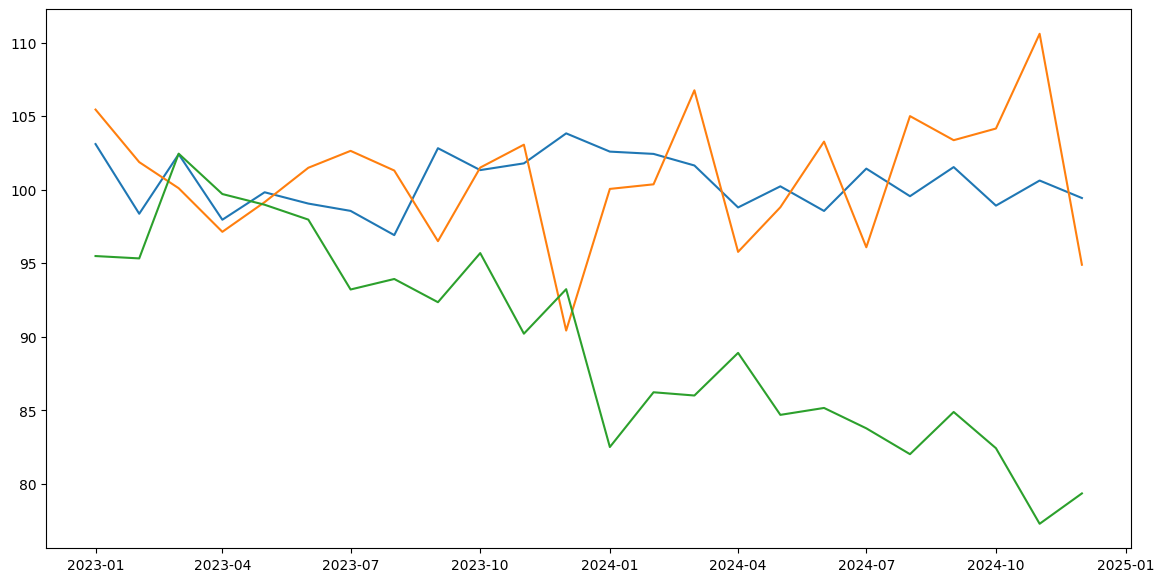

In [70]:
#extract product name 0 
produdct_0 = full_data[full_data['Product ID'] == 0][['Date', 'Value']]
product_50 = full_data[full_data['Product ID'] == 50][['Date', 'Value']]
product_last = full_data[full_data['Product ID'] == 119][['Date', 'Value']]

#plot all in one plot
plt.figure(figsize=(14, 7))
plt.plot(produdct_0['Date'], produdct_0['Value'], label='Product 0')
plt.plot(product_50['Date'], product_50['Value'], label='Product 50')
plt.plot(product_last['Date'], product_last['Value'], label='Product 119')




In [75]:
from dataclasses import dataclass, field
from typing import List, Dict, Any
import pandas as pd
import numpy as np
from random import choice

# Define a list of customers
customers = [f'Customer {i+1}' for i in range(20)]

def generate_time_series(pattern='flat', start_month='2023-01', months=12, seasonality_type='monthly', base_level=100):
    date_range = pd.date_range(start=start_month, periods=months, freq='MS')
    if pattern == 'flat':
        data = np.full(months, base_level) + np.random.normal(loc=0, scale=2, size=months)
    elif pattern == 'declining':
        data = np.linspace(base_level, base_level - 20, num=months) + np.random.normal(loc=0, scale=3, size=months)
    elif pattern == 'seasonal':
        if seasonality_type == 'monthly':
            frequency = months / 12
        elif seasonality_type == 'quarterly':
            frequency = months / 4
        elif seasonality_type == 'weekly':
            frequency = months * 4.34524  # Approx. weeks per month
        data = base_level + 20 * np.sin(2 * np.pi * np.arange(months) / frequency) + np.random.normal(loc=0, scale=5, size=months)
    elif pattern == 'random walk':
        random_steps = np.random.normal(loc=0, scale=1, size=months)
        data = np.cumsum(np.insert(random_steps, 0, base_level))[1:]
    return pd.Series(data, index=date_range)

@dataclass
class Product:
    id: int
    name: str
    customer: str = field(default_factory=lambda: choice(customers))
    settings: Dict[str, Any] = field(default_factory=dict)
    time_series: pd.Series = field(default_factory=pd.Series)

    def generate_data(self, global_settings):
        effective_settings = {**global_settings, **self.settings}
        self.time_series = generate_time_series(**effective_settings)

@dataclass
class Division:
    id: int
    name: str
    products: List[Product] = field(default_factory=list)

@dataclass
class Segment:
    id: int
    name: str
    divisions: List[Division] = field(default_factory=list)
    settings: Dict[str, Any] = field(default_factory=dict)

def initialize_hierarchy(global_settings, segment_specific_settings={}):
    segments = []
    for i in range(4):  # Assuming 4 segments
        segment_settings = segment_specific_settings.get(f'Segment {i+1}', {})
        effective_segment_settings = {**global_settings, **segment_settings}
        divisions = []
        for j in range(3):  # Each segment has 3 divisions
            products = []
            for k in range(10):  # Each division has 10 products
                base_level = np.random.choice([50, 100, 150], p=[0.3, 0.6, 0.1])  # Example probabilities for base level
                product = Product(id=i*30 + j*10 + k, name=f'Product {i*30 + j*10 + k}', settings=effective_segment_settings)
                product.generate_data(effective_segment_settings)
                products.append(product)
            divisions.append(Division(id=j+1, name=f'Division {j+1}', products=products))
        segments.append(Segment(id=i+1, name=f'Segment {i+1}', divisions=divisions, settings=segment_settings))
    return segments

# Define global settings
global_settings = {
    'start_month': '2023-01',
    'months': 24,
    'pattern': 'flat',
    'seasonality_type': 'monthly',
    'base_level': 100
}

# Define custom settings for specific segments
segment_specific_settings = {
    'Segment 1': {
        'pattern': 'seasonal',
        'seasonality_type': 'quarterly',
        'base_level': 150
    }
}

segments = initialize_hierarchy(global_settings, segment_specific_settings)
full_data = create_full_dataframe(segments)
print(full_data.head())


UnboundLocalError: cannot access local variable 'data' where it is not associated with a value

In [72]:
full_data

,Segment ID,Segment Name,Division ID,Division Name,Product ID,Product Name,Date,Value
0,1,Segment 1,1,Division 1,0,Product 0,2023-01-01,154.255667
1,1,Segment 1,1,Division 1,0,Product 0,2023-02-01,171.509551
2,1,Segment 1,1,Division 1,0,Product 0,2023-03-01,165.281970
3,1,Segment 1,1,Division 1,0,Product 0,2023-04-01,147.734765
4,1,Segment 1,1,Division 1,0,Product 0,2023-05-01,133.233373
...,...,...,...,...,...,...,...,...
2875,4,Segment 4,3,Division 3,119,Product 119,2024-08-01,98.980633
2876,4,Segment 4,3,Division 3,119,Product 119,2024-09-01,100.844746
2877,4,Segment 4,3,Division 3,119,Product 119,2024-10-01,101.261634
2878,4,Segment 4,3,Division 3,119,Product 119,2024-11-01,98.543807


In [86]:
import numpy as np
import pandas as pd
from random import choice

def generate_time_series(pattern='flat', start_month='2023-01', days=365, seasonality_type='monthly', base_level=100):
    date_range = pd.date_range(start=start_month, periods=days, freq='D')  # 'D' for Daily frequency
    
    if pattern == 'flat':
        data = np.full(days, base_level) + np.random.normal(loc=0, scale=2, size=days)
    elif pattern == 'declining':
        data = np.linspace(base_level, base_level - 20, num=days) + np.random.normal(loc=0, scale=3, size=days)
    elif pattern == 'seasonal':
        if seasonality_type == 'monthly':
            frequency = days / 30  # Approximate number of days in a month
        elif seasonality_type == 'quarterly':
            frequency = days / 90  # Approximate number of days in a quarter
        elif seasonality_type == 'weekly':
            frequency = days / 7   # Number of days in a week
        data = base_level + 20 * np.sin(2 * np.pi * np.arange(days) / frequency) + np.random.normal(loc=0, scale=5, size=days)
    elif pattern == 'random walk':
        random_steps = np.random.normal(loc=0, scale=1, size=days)
        data = np.cumsum(np.insert(random_steps, 0, base_level))[1:]
    return pd.Series(data, index=date_range)

# List of customers
customers = [f'Customer {i+1}' for i in range(20)]

@dataclass
class Product:
    id: int
    name: str
    customer: str = field(default_factory=lambda: choice(customers))
    settings: Dict[str, Any] = field(default_factory=dict)
    time_series: pd.Series = field(default_factory=pd.Series)

    def generate_data(self, global_settings):
        effective_settings = {**global_settings, **self.settings}
        self.time_series = generate_time_series(**effective_settings)

from dataclasses import dataclass, field
from typing import List, Dict, Any

@dataclass
class Division:
    id: int
    name: str
    products: List[Product] = field(default_factory=list)

@dataclass
class Segment:
    id: int
    name: str
    divisions: List[Division] = field(default_factory=list)
    settings: Dict[str, Any] = field(default_factory=dict)

def initialize_hierarchy(global_settings, segment_specific_settings={}):
    segments = []
    for i in range(4):  # Assuming 4 segments
        segment_settings = segment_specific_settings.get(f'Segment {i+1}', {})
        effective_segment_settings = {**global_settings, **segment_settings}
        divisions = []
        for j in range(3):  # Each segment has 3 divisions
            products = []
            for k in range(10):  # Each division has 10 products
                base_level = np.random.choice([50, 100, 150], p=[0.3, 0.6, 0.1])  # Example probabilities for base level
                product = Product(id=i*30 + j*10 + k, name=f'Product {i*30 + j*10 + k}', settings=effective_segment_settings)
                product.generate_data(effective_segment_settings)
                products.append(product)
            divisions.append(Division(id=j+1, name=f'Division {j+1}', products=products))
        segments.append(Segment(id=i+1, name=f'Segment {i+1}', divisions=divisions, settings=segment_settings))
    return segments

# Define global settings
global_settings = {
    'start_month': '2023-01',
    'days': 365,  # Generate data for one year
    'pattern': 'flat',
    'seasonality_type': 'monthly',
    'base_level': 100
}

# Define custom settings for specific segments
segment_specific_settings = {
    'Segment 1': {
        'pattern': 'seasonal',
        'seasonality_type': 'quarterly',
        'base_level': 10
    }
}

segments = initialize_hierarchy(global_settings, segment_specific_settings)
full_data = create_full_dataframe(segments)
full_data


,Segment ID,Segment Name,Division ID,Division Name,Product ID,Product Name,Customer,Date,Value,Cumulative_Value
0,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-01,9.133894,9.133894
1,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-02,26.128670,35.262564
2,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-03,10.710364,45.972928
3,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-04,-15.655940,30.316988
4,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-05,5.631957,35.948945
...,...,...,...,...,...,...,...,...,...,...
43795,4,Segment 4,3,Division 3,119,Product 119,Customer 18,2023-12-27,97.961853,36084.299486
43796,4,Segment 4,3,Division 3,119,Product 119,Customer 18,2023-12-28,101.179342,36185.478828
43797,4,Segment 4,3,Division 3,119,Product 119,Customer 18,2023-12-29,98.965628,36284.444456
43798,4,Segment 4,3,Division 3,119,Product 119,Customer 18,2023-12-30,97.743172,36382.187628


In [2]:
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import List, Dict, Any
from random import choice

def generate_time_series(pattern='flat', start_month='2023-01', days=365, seasonality_type='monthly', base_level=100):
    if pattern == 'random':
        pattern = np.random.choice(['flat', 'declining', 'seasonal', 'random walk'])


    date_range = pd.date_range(start=start_month, periods=days, freq='D')
    if pattern == 'flat':
        data = np.full(days, base_level) + np.random.normal(loc=0, scale=2, size=days)
    elif pattern == 'declining':
        data = np.linspace(base_level, base_level - 20, num=days) + np.random.normal(loc=0, scale=3, size=days)
    elif pattern == 'seasonal':
        if seasonality_type == 'monthly':
            frequency = days / 30  # Approximate number of days in a month
        elif seasonality_type == 'quarterly':
            frequency = days / 90  # Approximate number of days in a quarter
        elif seasonality_type == 'weekly':
            frequency = days / 7   # Number of days in a week
        data = base_level + 20 * np.sin(2 * np.pi * np.arange(days) / frequency) + np.random.normal(loc=0, scale=5, size=days)
    
    elif pattern == 'random walk':
        random_steps = np.random.normal(loc=0, scale=1, size=days)
        data = np.cumsum(np.insert(random_steps, 0, base_level))[1:]
    return pd.Series(data, index=date_range)

@dataclass
class Product:
    id: int
    name: str
    customer: str = field(default_factory=lambda: choice([f'Customer {i+1}' for i in range(20)]))
    settings: Dict[str, Any] = field(default_factory=dict)
    time_series: pd.Series = field(default_factory=pd.Series)

    def generate_data(self):
        self.time_series = generate_time_series(**self.settings)

@dataclass
class Division:
    id: int
    name: str
    products: List[Product] = field(default_factory=list)

@dataclass
class Segment:
    id: int
    name: str
    divisions: List[Division] = field(default_factory=list)
    settings: Dict[str, Any] = field(default_factory=dict)

def initialize_hierarchy(global_settings, segment_specific_settings={}):
    segments = []
    for i in range(4):  # Assuming 4 segments
        segment_settings = segment_specific_settings.get(f'Segment {i+1}', {})
        effective_segment_settings = {**global_settings, **segment_settings}
        divisions = []
        for j in range(3):  # Each segment has 3 divisions
            products = []
            for k in range(10):  # Each division has 10 products
                base_level = np.random.choice([50, 100, 150], p=[0.3, 0.6, 0.1])  # Example probabilities for base level
                product_settings = {**effective_segment_settings, 'base_level': base_level}
                product = Product(id=i*30 + j*10 + k, name=f'Product {i*30 + j*10 + k}', settings=product_settings)
                product.generate_data()
                products.append(product)
            divisions.append(Division(id=j+1, name=f'Division {j+1}', products=products))
        segments.append(Segment(id=i+1, name=f'Segment {i+1}', divisions=divisions, settings=segment_settings))
    return segments

# Define global settings
global_settings = {
    'start_month': '2023-01',
    'days': 365,  # Generate data for one year
    'pattern': 'flat',
    'seasonality_type': 'monthly'
}

# Define custom settings for specific segments
segment_specific_settings = {
    'Segment 1': {
        'pattern': 'random',
        'seasonality_type': 'quarterly',
        'base_level': 150
    },
    'Segment 3': {
        'pattern': 'declining'
    }
}

segments = initialize_hierarchy(global_settings, segment_specific_settings)

def create_full_dataframe(segments):
    data_rows = []
    for segment in segments:
        for division in segment.divisions:
            for product in division.products:
                for date, value in product.time_series.items():
                    data_rows.append({
                        'Segment ID': segment.id,
                        'Segment Name': segment.name,
                        'Division ID': division.id,
                        'Division Name': division.name,
                        'Product ID': product.id,
                        'Product Name': product.name,
                        'Customer': product.customer,
                        'Date': date,
                        'Value': value
                    })
    
    return pd.DataFrame(data_rows).assign(Cumulative_Value=lambda x: x.groupby('Product ID')['Value'].cumsum())

full_data = create_full_dataframe(segments)
print(full_data.head())


   Segment ID Segment Name  Division ID Division Name  Product ID  \
0           1    Segment 1            1    Division 1           0   
1           1    Segment 1            1    Division 1           0   
2           1    Segment 1            1    Division 1           0   
3           1    Segment 1            1    Division 1           0   
4           1    Segment 1            1    Division 1           0   

  Product Name     Customer       Date      Value  Cumulative_Value  
0    Product 0  Customer 20 2023-01-01  45.216508         45.216508  
1    Product 0  Customer 20 2023-01-02  68.097889        113.314398  
2    Product 0  Customer 20 2023-01-03  53.595909        166.910307  
3    Product 0  Customer 20 2023-01-04  19.235770        186.146077  
4    Product 0  Customer 20 2023-01-05  40.347876        226.493952  


In [3]:
full_data

,Segment ID,Segment Name,Division ID,Division Name,Product ID,Product Name,Customer,Date,Value,Cumulative_Value
0,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-01,45.216508,45.216508
1,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-02,68.097889,113.314398
2,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-03,53.595909,166.910307
3,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-04,19.235770,186.146077
4,1,Segment 1,1,Division 1,0,Product 0,Customer 20,2023-01-05,40.347876,226.493952
...,...,...,...,...,...,...,...,...,...,...
43795,4,Segment 4,3,Division 3,119,Product 119,Customer 2,2023-12-27,100.987618,36057.775606
43796,4,Segment 4,3,Division 3,119,Product 119,Customer 2,2023-12-28,98.370862,36156.146468
43797,4,Segment 4,3,Division 3,119,Product 119,Customer 2,2023-12-29,101.685543,36257.832010
43798,4,Segment 4,3,Division 3,119,Product 119,Customer 2,2023-12-30,100.265984,36358.097995


In [8]:
#count unique products
unique_products = full_data['Product ID'].nunique()
print(f'Number of unique products: {unique_products}')

Number of unique products: 120


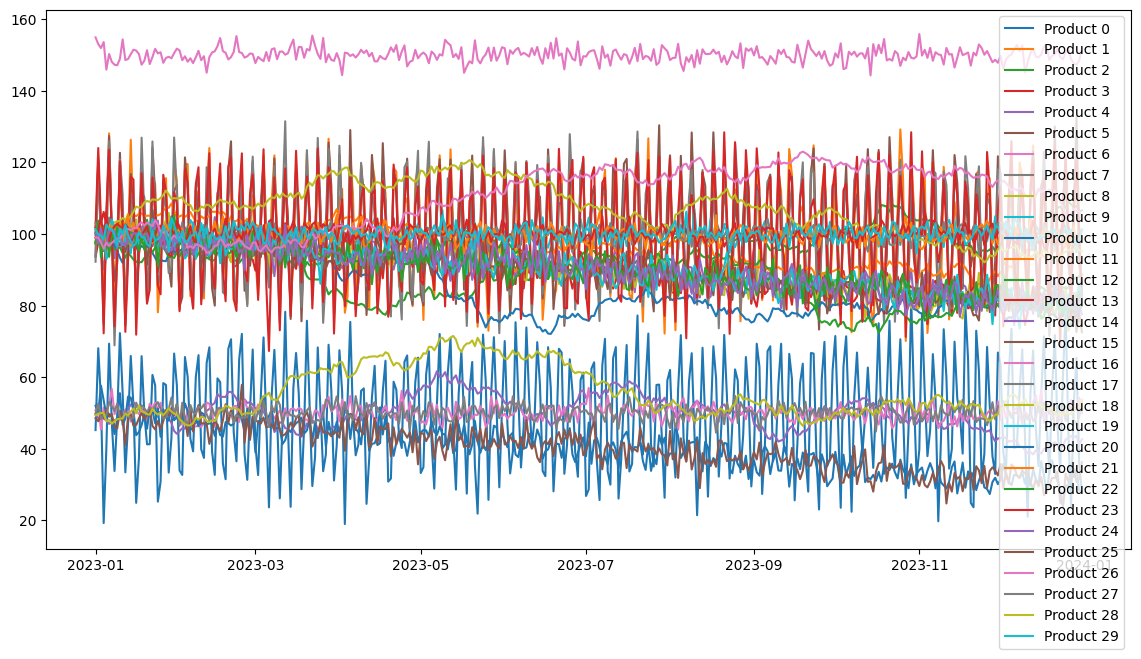

In [7]:
#set date as index
import matplotlib.pyplot as plt
#plot products in segment 1
segment_1_data = full_data[full_data['Segment ID'] == 1]


#plot all products in segment 1
plt.figure(figsize=(14, 7))
for product_id in segment_1_data['Product ID'].unique():
    product_data = segment_1_data[segment_1_data['Product ID'] == product_id]
    plt.plot(product_data['Date'], product_data['Value'], label=f'Product {product_id}')
plt.legend()
plt.show()

